# Evaluating Simpler Models on collected data

Because a Neural Net seems like overkill.

In [2]:
import os
import time
from datetime import date

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.core.display import display

In [3]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"


In [4]:
def convert_datetime_to_epoch_time(date):
    return (date.astype("uint64") / 1e9).astype("uint32")

def prepare_df_for_gp(frame, prediction_column="grindersetting", encoders={}, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        try:
            new_frame = new_frame.drop([col], axis=1)
        except KeyError:
            continue
    for col, encoder in encoders.items():
        if col not in new_frame:
            if col not in drop_cols:
                print("No such column:", col)
            continue
        vals = encoder.transform(np.asarray(new_frame[col]).reshape(-1, 1))
        new_frame[col] = [vals[i] for i in range(len(vals))] 
        
    
    y = np.asarray(new_frame[prediction_column])
    for drop_col in [prediction_column]:
        try:
            new_frame = new_frame.drop(drop_col, axis=1)
        except KeyError:
            continue
    # Sort the columns so the ordering is consistent
    cols = list(sorted(new_frame.columns.tolist()))
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    frame_array = new_frame[cols].to_numpy()
    x = np.zeros((frame_array.shape[0], np.hstack(frame_array[0]).shape[0]))
    # Surely there is a way to vectorize this?
    for i in range(frame_array.shape[0]):
        x[i] = np.hstack(frame_array[i])
    
    return x, y

def find_columns_to_drop(df, skipped_columns=None):
    if skipped_columns is None:
        skipped_columns = set()
    droppable_columns = []
    for col in df.columns:
        if col in skipped_columns:
            continue
        # Drop any column that is mostly NaNs
        if np.count_nonzero(df[col].isna()) > 0.5 * len(df[col]):
            droppable_columns.append(col)
    return droppable_columns

In [13]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
invalid_indices = df[df["time"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df[pd.to_numeric(df["grindersetting"], errors="coerce").notnull()]
df["roastdate"] = pd.to_datetime(df.roastdate, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
df["date"] = pd.to_datetime(df.date, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
df["timesinceroast"] = df["date"] - df["roastdate"]
df["grindersetting"] = df["grindersetting"].astype(np.float64)
df[["roaster", "coffee"]] = df["coffee"].str.lower().str.split('-', 1, expand=True)
df["coffee"] = df["coffee"].astype(str).replace("None", "").str.strip()
df["machineprofile"] = df["machineprofile"].fillna("").replace("", "default").str.lower()
df["roaster"] = df["roaster"].str.strip()
df["brewratio"] = df["output"] / df["coffeegrams"] 

encoded_cols = ("grinder", "coffee", "roaster", "machine", "machineprofile")

for col in find_columns_to_drop(df):
    if col in encoded_cols:
        continue
    print("Dropping", col)
    df = df.drop(col, axis=1)

encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    if len(df[col].unique()) <= 1:
        print(f"Column {col} has 1 or fewer values, not encoding")
        continue
#     encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    print("Encoding", col)
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=len(df[col].unique()))
    encoder.fit(np.asarray(df[col]).reshape(-1, 1))
    encs[col] = encoder

# Drop fields that aren't going to be encoded or are a pandas type
for field in df.columns:
    if field in encs:
        continue
    if df[field].dtype == object:
        print("Dropping", field)
        df = df.drop([field], axis=1)

for col in ["arbitraryrating1-10"]:
    if col in df.columns:
        print("Dropping", col)
        df = df.drop(col, axis=1)


Dropping timeprediction
Dropping tdsatagounfiltered
Dropping tdstempc
Encoding grinder
Encoding coffee
Encoding roaster
Encoding machine
Encoding machineprofile
Dropping details
Dropping arbitraryrating1-10


## Use distribution of grams of coffee in to enhance data

Initially values were just the grams weighed before grinding. After getting a more precise scale, data has been collected after grinding/prep, want to see if using that data can enhance the training.

In [14]:
def resample_field(frame, field: str, samples: int = 3, seed: int = 814):
    to_sample = frame.copy()
    # Duplicate a bunch of samples
    to_sample = pd.concat([to_sample]*samples)
    mean = np.mean(to_sample[field])
    std = np.std(to_sample[field])
    state = np.random.RandomState(seed)
    samples = state.normal(mean, std, size=len(to_sample))
#     updated = np.where(np.abs(to_sample[field].values - samples) < std * 2, samples, np.nan)
    to_sample[field] = samples.tolist()
    if field in ["coffeegrams", "output"]:
        to_sample.brewratio = to_sample.output / to_sample.coffeegrams
    sampled = to_sample[np.logical_not(np.isnan(to_sample[field]))]
    return sampled

In [15]:


def construct_regressor(estimators=1700):
    # Optimized using skopt
    return  GradientBoostingRegressor(
        n_estimators=estimators,
#         max_depth=5,
#         learning_rate=0.003993,
#         max_features=7,
#         min_samples_split=2,
#         min_samples_leaf=1,
        random_state=814
    )

## Evaluate using GradientBoosting to make predictions

It is feasible to build a personalized GradientBoost model, and this is to do a basic proof of concept to see if it isn't totally worthless.

Prediction grindersetting
With Dropped columns: ('brewratio', 'date', 'roastdate')


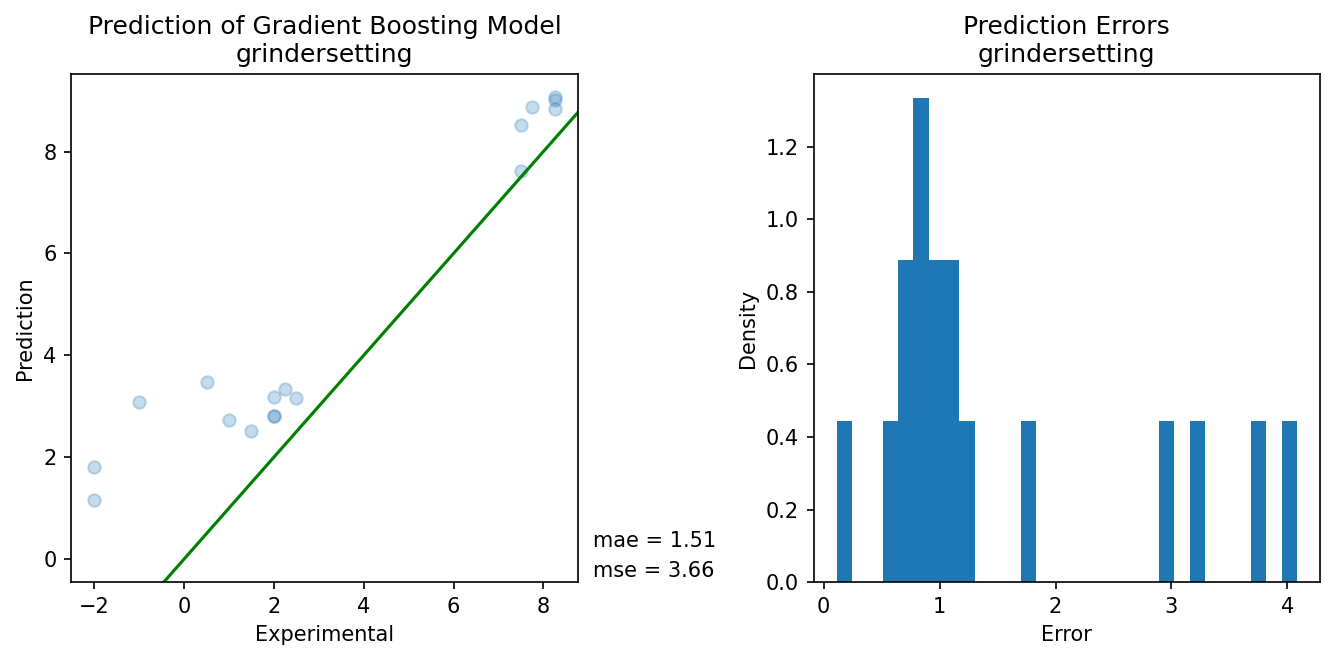

With Dropped columns: ('output', 'date', 'roastdate')


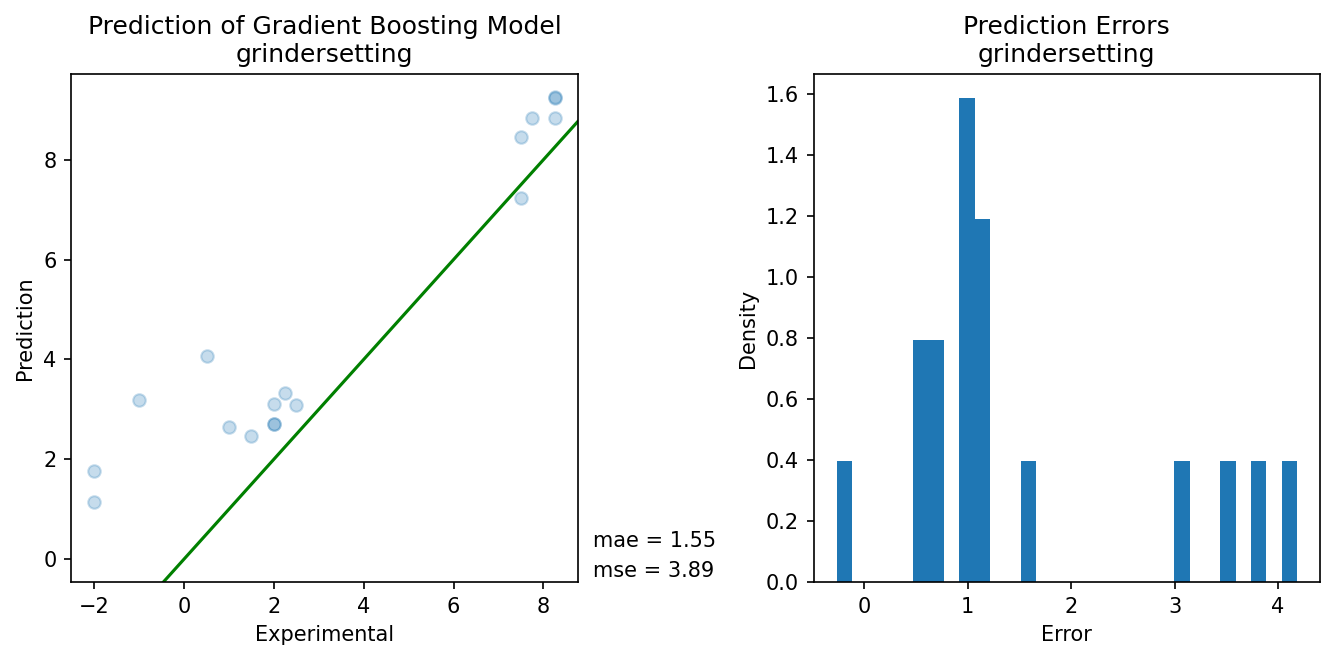

Prediction time
With Dropped columns: ('brewratio', 'date', 'roastdate')


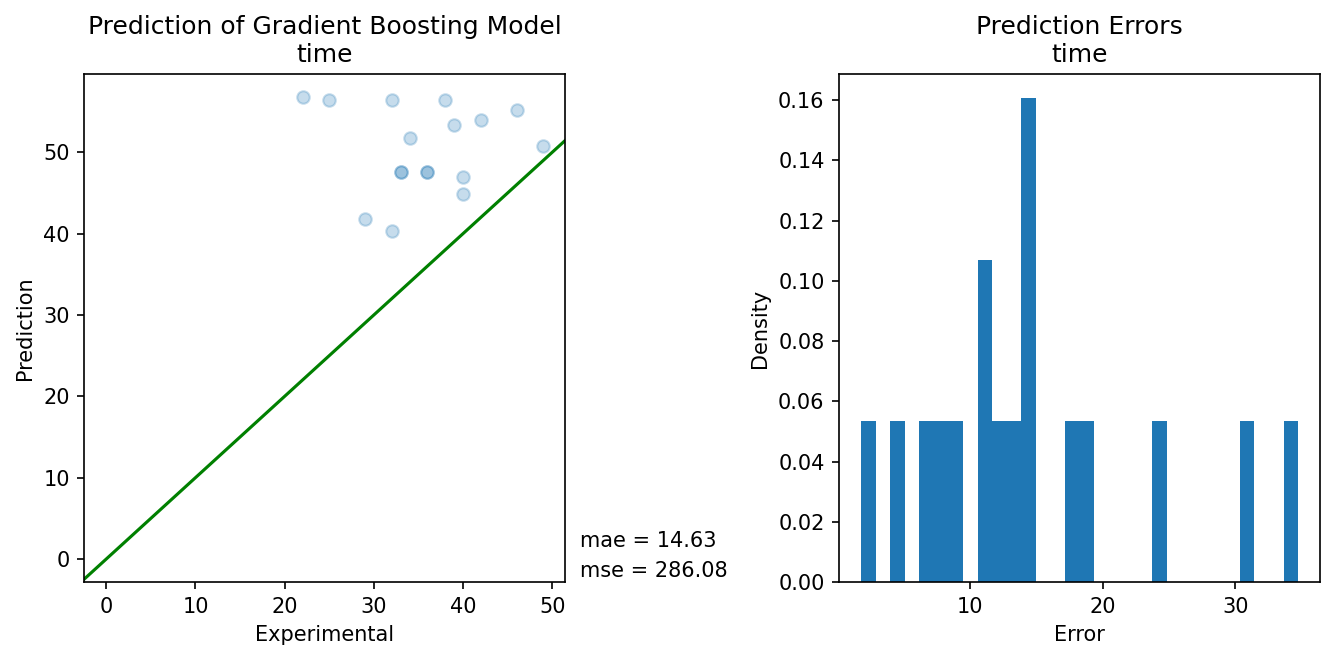

With Dropped columns: ('output', 'date', 'roastdate')


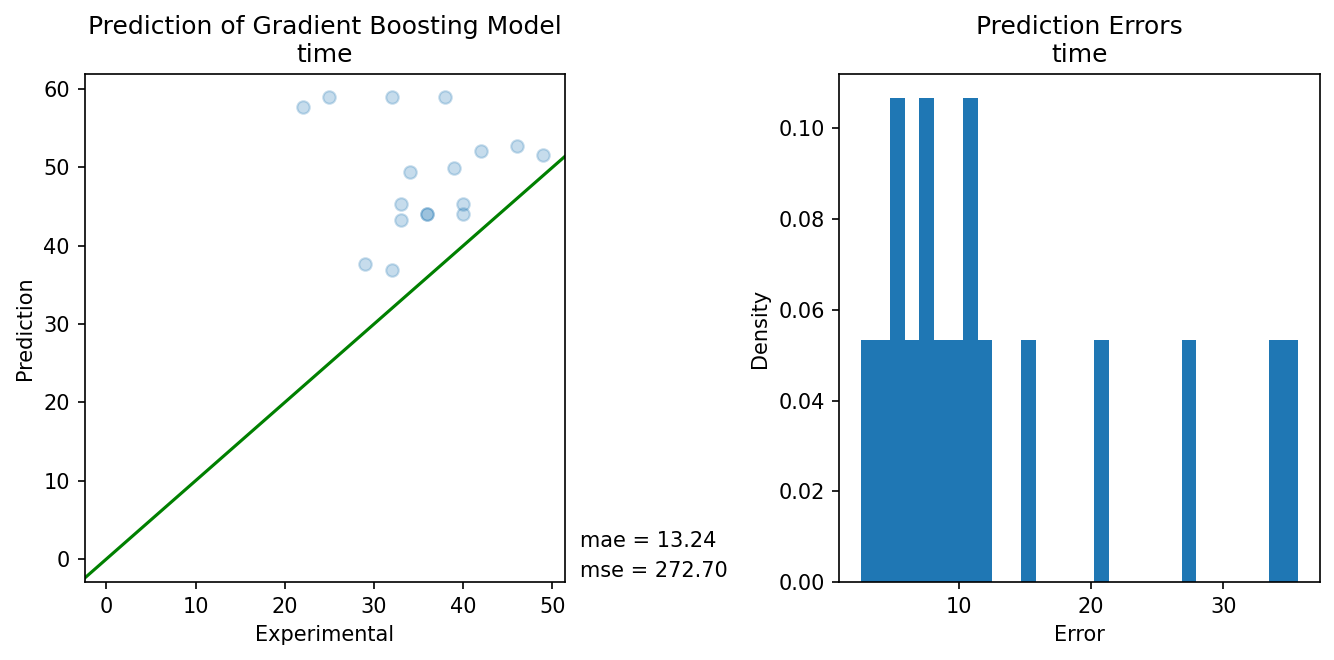

In [16]:
# Samples values for the training set
enhance_sample = True
k_folds = False

estimators = 1700
for prediction_field in ["grindersetting", "time"]:
    print("Prediction", prediction_field)
    for dropped in [("brewratio", "date", "roastdate"), ("output", "date", "roastdate")]:
        print("With Dropped columns:", dropped)
        mae_scores = []
        mse_scores = []
        fig, (ax, ax2) = plt.subplots(ncols=2, dpi=150, figsize=(9, 4.5))
        data = df
        true_vals = None
        pred = None
        if k_folds:
            regr = construct_regressor()
            if enhance_sample:
                sampled_coffee = resample_field(data, "coffeegrams")
                sampled_output = resample_field(data, "output")
                data = pd.concat([data, sampled_coffee, sampled_output])
            x, y = prepare_df_for_gp(data, prediction_column=prediction_field, drop_cols=dropped, encoders=encs)
            folds = KFold(n_splits=8, random_state=814, shuffle=True)
            for train_idx, test_idx in folds.split(x):
                x_train = x[train_idx]
                y_train = y[train_idx]

                x_test = x[test_idx]
                y_test = y[test_idx]

                regr.fit(x_train, y_train)

                yfit = regr.predict(x_test)
                ax.scatter(
                    y_test,
                    yfit,
                    marker="o",
                    alpha=0.25,
                )
                if true_vals is None:
                    true_vals = y_test
                    pred = yfit
                else:
                    true_vals = np.concatenate([true_vals, y_test])
                    pred = np.concatenate([pred, yfit])
                mae_scores.append(mean_absolute_error(y_test, yfit))
                mse_scores.append(mean_squared_error(y_test, yfit))
        else:
            latest_date = data.date.max()
            num_days = 5
            days_in_seconds = (24 * 60 * 60 * num_days)
            # Training data is everything a week before the most recent pull
            train = data[data.date < latest_date - days_in_seconds]
            test = data.drop(train.index)
            if enhance_sample:
                sampled_coffee = resample_field(train, "coffeegrams")
                sampled_output = resample_field(train, "output")
                train = pd.concat([train, sampled_coffee, sampled_output])
            x, y = prepare_df_for_gp(train, prediction_column=prediction_field, drop_cols=dropped, encoders=encs)
            regr = construct_regressor(estimators=estimators)
            regr.fit(x, y)
            x_test, y_test = prepare_df_for_gp(test, prediction_column=prediction_field, drop_cols=dropped, encoders=encs)
            yfit = regr.predict(x_test)
            ax.scatter(
                y_test,
                yfit,
                marker="o",
                alpha=0.25,
            )
            if true_vals is None:
                true_vals = y_test
                pred = yfit
            else:
                true_vals = np.concatenate([true_vals, y_test])
                pred = np.concatenate([pred, yfit])
            mae_scores.append(mean_absolute_error(y_test, yfit))
            mse_scores.append(mean_squared_error(y_test, yfit))
        ax.set_title(f"Prediction of Gradient Boosting Model\n{prediction_field}")
        ax.set_xlabel("Experimental")
        ax.set_ylabel("Prediction")
        ax.axline([0, 0], [1, 1], color="g", label="fit")
        ax.annotate(
            "mse = {:.2f}".format(mean_squared_error(true_vals, pred)),
            (1.03, 0.01),
            xycoords="axes fraction",
        )
        ax.annotate(
            "mae = {:.2f}".format(mean_absolute_error(true_vals, pred)),
            (1.03, 0.07),
            xycoords="axes fraction",
        )

        ax2.hist(pred - true_vals, bins=30, density=True)
        ax2.set_title(f"Prediction Errors\n{prediction_field}")
        ax2.set_xlabel("Error")
        ax2.set_ylabel("Density")
        fig.tight_layout()
        plt.show()

## Trying it out on new data

What happens if we throw 'novel' coffee at it, how well will it predict it across grinders?

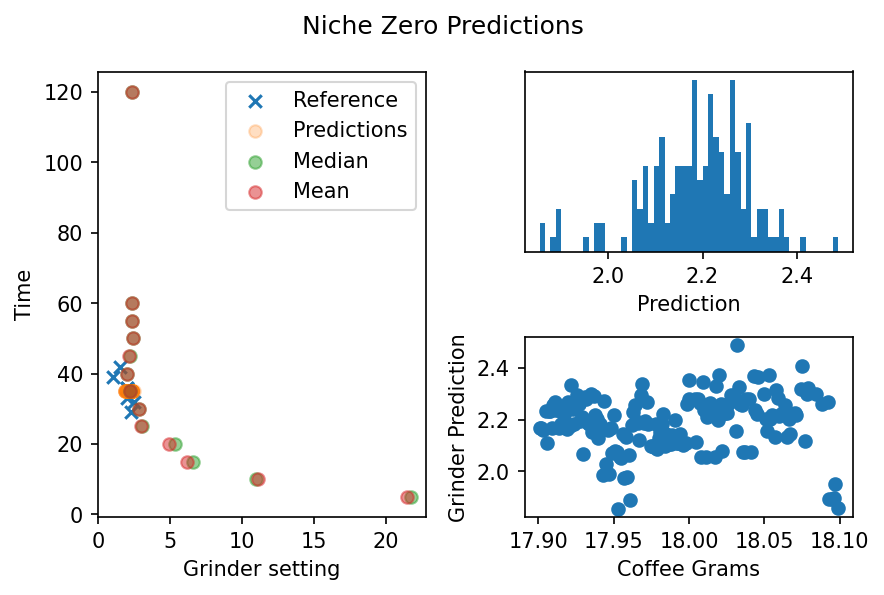

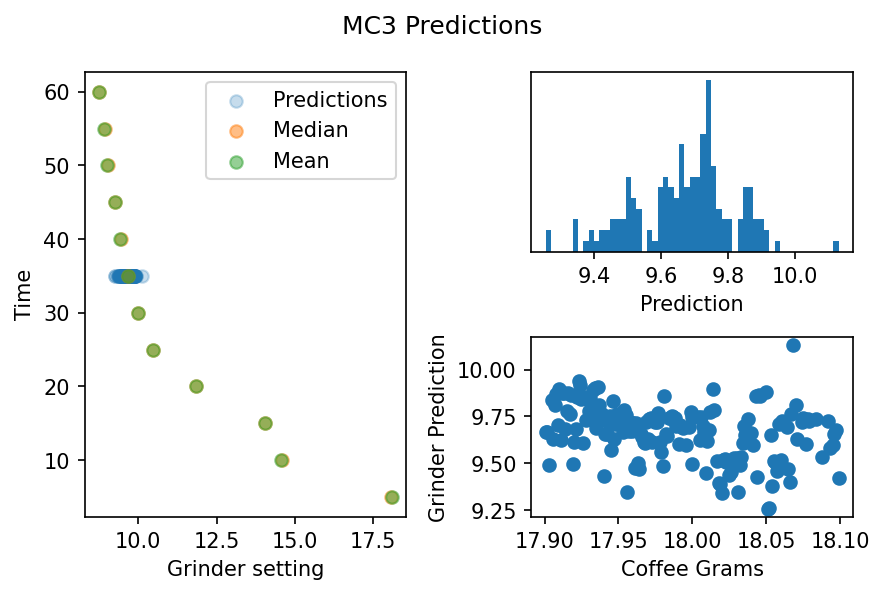

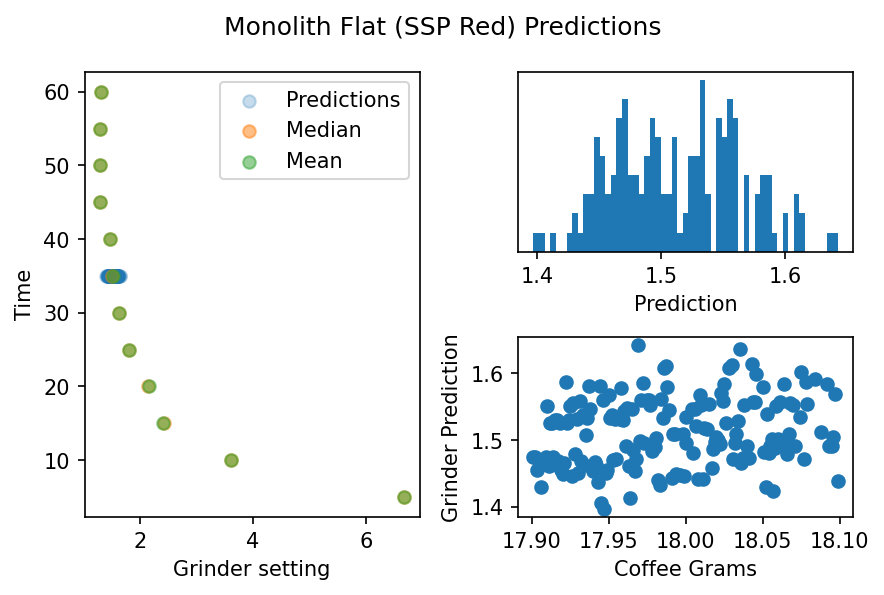

In [21]:
dropped = ("roastdate", "date", "brewratio", "grinder")
enhance_sample = True

data = {
    "coffee": ["Onyx - Geometry"],
    "coffeegrams": [18.0],
    "roastdate": ["06/14/22"],
    "time": [35],
    "brewratio": [df.brewratio.median()],
    "machine": "Decent DE1PRO",
    "machineprofile": "default"
}
training = df
if enhance_sample:
    sampled_coffee = resample_field(training[training.machine == data["machine"]], "coffeegrams", samples=20)
    sampled_output = resample_field(training[training.machine == data["machine"]], "output", samples=20)
    training = pd.concat([training, sampled_coffee, sampled_output])



data["date"] = [date.today().strftime("%m/%d/%Y")]
data["grindersetting"] = [0.5] # Meaningless value
data["output"] = [np.round(data["brewratio"][0] * data["coffeegrams"][0], 1)]
test_df = pd.DataFrame.from_dict(data)
test_df[["roaster", "coffee"]] = test_df["coffee"].str.lower().str.split('-', 1, expand=True)
test_df["coffee"] = test_df["coffee"].str.replace("None", "").str.strip()
test_df["roaster"] = test_df["roaster"].str.strip()
if test_df["roaster"].values[0] not in df.roaster.values:
    print("No matching roaster found", test_df["roaster"].values[0])
    print("-----")
if test_df["coffee"].values[0] not in df.coffee.values:
    print("No matching coffee found", test_df["coffee"].values[0])
    print("-----")
test_df.roastdate = pd.to_datetime(test_df.roastdate, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
test_df.date = pd.to_datetime(test_df.date, infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)
test_df["timesinceroast"] = test_df.date - test_df.roastdate


for grinder in df.grinder.unique():
    test_grinder_df = test_df.copy()
    test_df = test_grinder_df.assign(grinder=[grinder])
    grinder_df = df[(df.grinder == grinder)] # & (df.machine == test_grinder_df.machine.values[0])]
    if len(grinder_df) == 0:
        continue
    x, y = prepare_df_for_gp(grinder_df, drop_cols=dropped, encoders=encs)
    regr = construct_regressor()
    regr.fit(x, y)
    x_set = [prepare_df_for_gp(test_grinder_df, drop_cols=dropped, encoders=encs)[0][0]]
    # Look at the all the different coffeegrams values within a threshold
    for val in df.coffeegrams.unique():
        if np.abs(data["coffeegrams"][0] - val) >= 0.1:
            continue
        median_output = df[df.coffeegrams == val].output.median()
        if np.abs(median_output - data["output"][0]) > 2.5:
            continue
        test_grinder_df["coffeegrams"] = [val]
        test_grinder_df["output"] = [median_output]
        test_grinder_df["brewratio"] = test_grinder_df.output / test_grinder_df.coffeegrams
        x_test, _ = prepare_df_for_gp(test_grinder_df, drop_cols=dropped, encoders=encs)
        x_set.append(x_test[0])
        grams_idx = np.argwhere(x_set[-1] == val).reshape(-1)
    x_set = np.array(x_set)
    grams_x = x_set[:, grams_idx].reshape(-1)
    sample_pred = regr.predict(x_set)
    mean_pred = np.mean(sample_pred)
    med_pred = np.median(sample_pred)
    fig = plt.figure(dpi=150)
    fig.suptitle(f"{grinder} Predictions")
    plot1 = fig.add_subplot(222)
    plot2 = fig.add_subplot(224)
    plot3 = fig.add_subplot(121)
    plot1.hist(sample_pred, bins=min(100, len(sample_pred) // 3), label="Predictions", density=True)
    plot1.set_xlabel("Prediction")
    plot1.set_yticks([])
    plot2.scatter(grams_x, sample_pred, label="Predictions")
    plot2.set_xlabel("Coffee Grams")
    plot2.set_ylabel("Grinder Prediction")
    reference_vals = grinder_df[
        (grinder_df.coffee == test_grinder_df.coffee.values[0]) &
        (grinder_df.roaster == test_grinder_df.roaster.values[0]) &
        (grinder_df.roastdate == test_grinder_df.roastdate.values[0]) &
        (grinder_df.machine == test_grinder_df.machine.values[0]) &
        (grinder_df.machineprofile == test_grinder_df.machineprofile.values[0])
    ]
    times = []
    med = []
    mean = []
    for time in grinder_df.time.unique():
        if time % 5 != 0:
            continue
        test_grinder_df["time"] = [time]
        times.append(time)
        x_set = [prepare_df_for_gp(test_grinder_df, drop_cols=dropped, encoders=encs)[0][0]]
        # Look at the all the different coffeegrams values within a threshold
        for val in df.coffeegrams.unique():
            if np.abs(data["coffeegrams"][0] - val) >= 0.1:
                continue
            median_output = df[df.coffeegrams == val].output.median()
            if np.abs(median_output - data["output"][0]) > 2.5:
                continue
            test_grinder_df["coffeegrams"] = [val]
            test_grinder_df["output"] = [median_output]
            test_grinder_df["brewratio"] = test_grinder_df.output / test_grinder_df.coffeegrams
            x_test, _ = prepare_df_for_gp(test_grinder_df, drop_cols=dropped, encoders=encs)
            x_set.append(x_test[0])
        yfit = regr.predict(x_set)
        mean_pred = np.mean(yfit)
        med_pred = np.median(yfit)
        mean.append(mean_pred)
        med.append(med_pred)
            
    if len(reference_vals):
        plot3.scatter(reference_vals.grindersetting, reference_vals.time, label="Reference", marker="x")
    if len(sample_pred):
        plot3.scatter(sample_pred, [data["time"]] * len(sample_pred), label="Predictions", marker="o", alpha=0.25)
    plot3.scatter(med, times, label="Median", alpha=0.5)
    plot3.scatter(mean, times, label="Mean", alpha=0.5)

    plot3.set_ylabel("Time")
    plot3.set_xlabel("Grinder setting")
    plot3.legend()
    fig.tight_layout()
    plt.show()